<a id=top-page></a>

# Integrate `pykitPIV` with `LIMA`

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#synthetic-images">Generate synthetic images with pykitPIV</a></li>
        <ul>
        <li><a href="#synthetic-images-training-set">Training set</a></li>
        <li><a href="#synthetic-images-testing-set">Testing set</a></li>
        </ul>
    <li><a href="#train-LIMA">Train LIMA with the generated images</a></li>
        <ul>
        <li><a href="#synthetic-images-training-set">Prepare input dataset for LIMA</a></li>
        <li><a href="#synthetic-images-testing-set">Begin training</a></li>
        </ul>
</ol>
<p></p>
</div>
<br>

***

In [1]:
import argparse
import os
import time
import pytorch_lightning as pl
import torchvision.transforms
from rich import print
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cmcrameri.cm as cmc
import lima
from pykitPIV import Particle, FlowField, Motion, Image

<a id=synthetic-images></a>

***

## Generate synthetic images with `pykitPIV`

[Go to the top](#top-page)

In [2]:
image_size = (140,200)

In [3]:
size_buffer = 0

In [4]:
figsize = (5,3)

In [5]:
def generate_images(n_images, random_seed):

    # Instantiate an object of the Particle class:
    particles = Particle(n_images,
                         size=image_size,
                         size_buffer=size_buffer,
                         diameters=(4,4.1),
                         distances=(1,2),
                         densities=(0.05,0.1),
                         signal_to_noise=(5,20),
                         diameter_std=0.2,
                         seeding_mode='random',
                         random_seed=random_seed)

    # Instantiate an object of the FlowField class:
    flowfield = FlowField(n_images,
                          size=image_size,
                          size_buffer=size_buffer,
                          flow_mode='random',
                          gaussian_filters=(10,11),
                          n_gaussian_filter_iter=20,
                          sin_period=(30,300),
                          displacement=(0,10),
                          random_seed=random_seed)

    # Instantiate an object of the Motion class:
    motion = Motion(particles, 
                    flowfield, 
                    time_separation=0.1)

    # Instantiate an object of the Image class:
    image = Image(random_seed=random_seed)

    # Prepare images - - - - - - - - - - - - - - - - - - 

    image.add_particles(particles)
            
    motion.forward_euler(n_steps=10)
    
    image.add_motion(motion)
    
    image.add_reflected_light(exposures=(0.6,0.65),
                              maximum_intensity=2**16-1,
                              laser_beam_thickness=1,
                              laser_over_exposure=1,
                              laser_beam_shape=0.95,
                              alpha=1/10)

    return image

<a id=synthetic-images-training-set></a>

### Training set

[Go to the top](#top-page)

The training set will have 10 image pairs:

In [6]:
n_images = 10

We fix a random seed for generating the training set of PIV images:

In [7]:
training_random_seed = 100

In [8]:
image_train = generate_images(n_images, training_random_seed)

Particles added to the image.
Reflected light added to images I1.
Reflected light added to images I2.


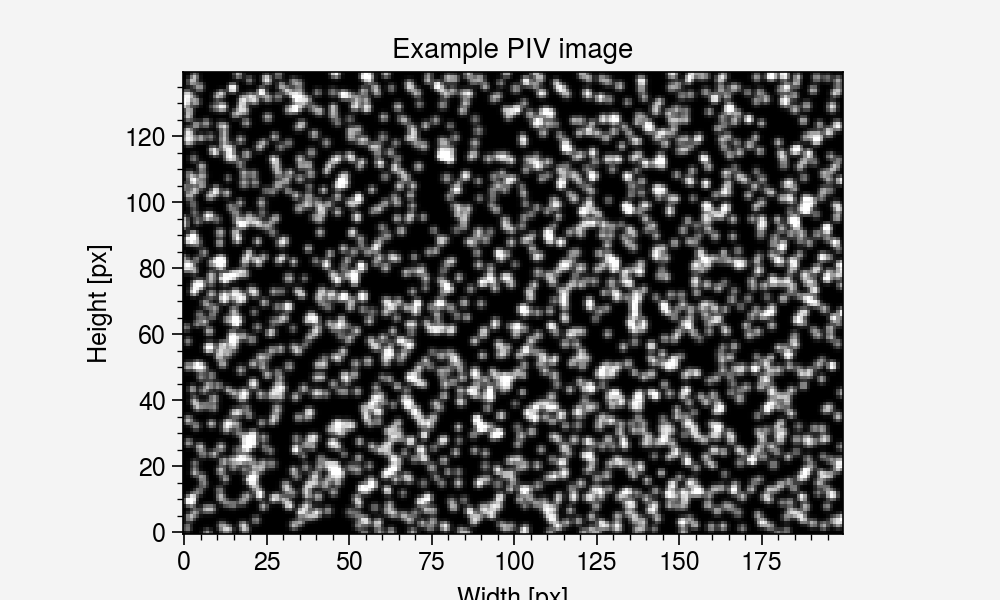

In [9]:
image_train.plot(0,
                 instance=1,
                 with_buffer=True,
                 xlabel='Width [px]',
                 ylabel='Height [px]',
                 title='Example PIV image',
                 cmap='Greys_r',
                 figsize=figsize);

<a id=synthetic-images-testing-set></a>

### Testing set

[Go to the top](#top-page)

The test set will have 10 image pairs:

In [10]:
n_images = 10

We fix a random seed for generating the test set of PIV images (which is different from the random seed for the training set):

In [11]:
test_random_seed = 200

In [12]:
image_test = generate_images(n_images, test_random_seed)

Particles added to the image.
Reflected light added to images I1.
Reflected light added to images I2.


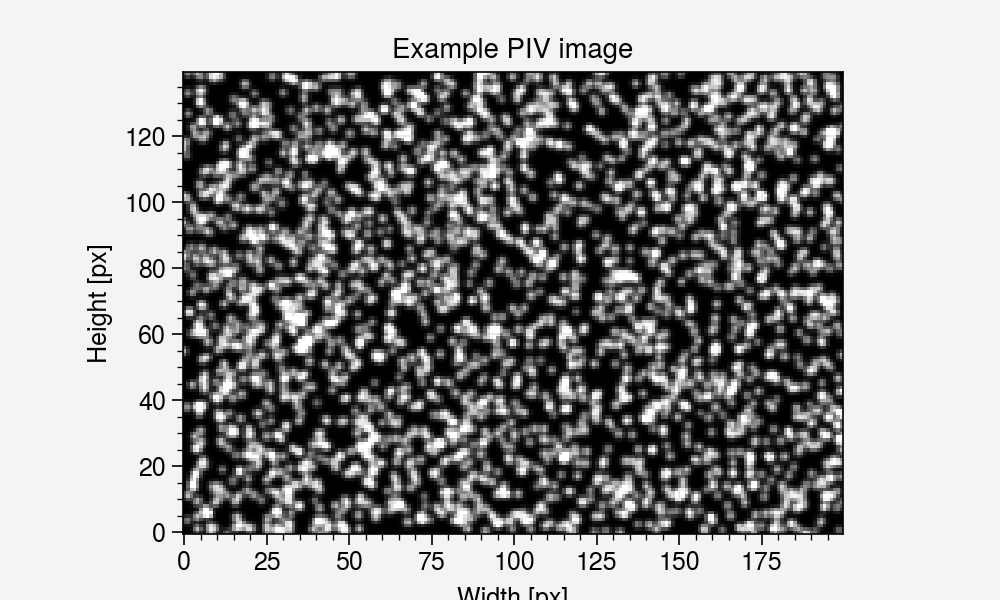

In [13]:
image_test.plot(0,
                instance=1,
                with_buffer=True,
                xlabel='Width [px]',
                ylabel='Height [px]',
                title='Example PIV image',
                cmap='Greys_r',
                figsize=figsize);

In [14]:
image_test.remove_buffers()

Images do not have a buffer to remove!


In [15]:
image_test.images_I1[0].shape

(140, 200)

In [16]:
image_test.images_I1_no_buffer[0].shape

(140, 200)

<a id=train-LIMA></a>
***

## Train `LIMA` with the generated images

[Go to the top](#top-page)

### Prepare input dataset for LIMA

[Go to the top](#top-page)

In [ ]:
transform = torchvision.transforms.Compose(
    [
        lima.transforms.RandomAffine(degrees=17, translate=(0.2, 0.2), scale=(0.9, 2.0)),
        lima.transforms.RandomHorizontalFlip(),
        lima.transforms.RandomVerticalFlip(),
        lima.transforms.ToTensor(),
        lima.transforms.NormalizeBounded(bit_depth=8 if args.dataset == "num" else 16),
        lima.transforms.RandomBrightness(factor=(0.5, 2)),
        lima.transforms.RandomNoise(std=(0, args.noise_std)),
    ]
)

datasets_path = {
    "rand_L_lag": (
        "../data/random_256px_train_n18278_lagrangian.mat",
        "../data/random_256px_test_n18278_lagrangian.mat",
    ),
}

args.train_dataset = datasets_path[args.dataset][0]
args.test_dataset = datasets_path[args.dataset][1]

if args.dataset in ["rand_L_lag", "rand_VL_lag"]:
    train_dataset = lima.dataset.MATLABDataset(
        path=args.train_dataset,
        transform=transform,
    )
    test_dataset = lima.dataset.MATLABDataset(
        path=args.test_dataset,
        transform=transform,
    )
else:
    train_dataset = lima.dataset.HDF5Dataset(
        path=args.train_dataset,
        transform=transform,
    )
    test_dataset = lima.dataset.HDF5Dataset(
        path=args.test_dataset,
        transform=transform,
    )

train_loader = DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=args.num_workers,
    pin_memory=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=args.batch_size,
)

return train_loader, test_loader

In [ ]:
parser = argument_parser()
parser = pl.Trainer.add_argparse_args(parser)
args = parser.parse_args()
main(args)


### Begin training

[Go to the top](#top-page)

In [ ]:
# 1. Log
dict_args = vars(args)
print(dict_args)

pl.seed_everything(args.seed, workers=True)

# 2. Setup train/test dataset
train_loader, test_loader = get_train_test_loader(args)
args.len_train_loader = len(train_loader)

# 3. Define the model
model = lima.LIMA(**dict_args)

# 4. Define logger
logger = pl.loggers.WandbLogger(
    project=args.project,
    entity="empa305",
    name=args.run,
    save_dir=os.path.join(os.path.dirname(__file__), "logs"),
    log_model=True,
)
logger.watch(model, log="all")

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="val_loss",
    save_top_k=1,
)

# 5. Setup trainer
trainer = pl.Trainer.from_argparse_args(
    args,
    accelerator=None if args.num_nodes == 1 else "ddp",
    gpus=1,
    logger=logger,
    max_epochs=args.epochs,
    callbacks=[checkpoint_callback, pl.callbacks.RichProgressBar()],
)

# 6. Train the model
trainer.fit(model, train_loader, test_loader)


***